# Population Data Task - esure
#### By Jack Stephens
***

#### <u>Instructions</u>

Using population data from the Data tab:<br>
a) Identify top 3 countries with highest population growth from 2015 to 2019. Present graphically.<br>
b) Identify top 3 countries with highest population decline from 2010 to 2015. Present graphically.<br>
c) Forecast population of the UK and Germany for 2020-2025. Explain your approach.<br>
d) Present the population data from 2008 and 2019 in a way that it is easy for the viewer to understand the magnitudes of population across the data set.<br>
e) How did population of countries listed change from 2012 to 2013 (exclude countries with incomplete data)?
***

## 1) ETL (Extract, Transform, Load)

Firstly, we will read in the dataset and perform data-cleaning operations to wrangle the set into appropriate format.

In [159]:
import pandas as pd

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None, 'display.max_columns', None)

data = pd.read_excel('data/population.xlsx', sheet_name='Data', skiprows=2)

View our full dataset

In [160]:
data

,geo\time,2008,Unnamed: 2,2009,Unnamed: 4,2010,Unnamed: 6,2011,Unnamed: 8,2012,Unnamed: 10,2013,Unnamed: 12,2014,Unnamed: 14,2015,Unnamed: 16,2016,Unnamed: 18,2017,Unnamed: 20,2018,Unnamed: 22,2019,Unnamed: 24
0,EU (27 countries - from 2020),438725386,(b),440047892,NaN,440660421,(b),439942305,(b),440552661,(b),441257711,NaN,442883888,(b),443666812,(b),444802830,NaN,445534430,(b),446098424,(p),446824564,(ep)
1,EU (28 countries),500297033,(b),502090235,NaN,503170618,(b),502964837,(b),504047749,(b),505163053,NaN,507235091,(b),508520205,(b),510181874,NaN,511378572,(b),512372000,(p),513471676,(ep)
2,EU (27 countries - 2007-2013),495985066,(b),497780439,NaN,498867771,(b),498674980,(b),499771765,(b),500900913,NaN,502988282,(b),504294889,(b),505991205,NaN,507224359,(b),508266507,(p),509395430,(ep)
3,Euro area - 19 countries (from 2015),333096775,(b),334470255,NaN,335266424,NaN,334572589,(b),335288924,(b),336044966,NaN,337764352,(b),338562121,(b),339787987,NaN,340541142,(b),341145721,(p),341902187,(ep)
4,Euro area - 18 countries (2014),329884170,(b),331286399,NaN,332124448,NaN,331520001,(b),332285283,(b),333073061,NaN,334820880,(b),335640859,(b),336899429,NaN,337693238,(b),338336820,(p),339108003,(ep)
5,Belgium,10666866,NaN,10753080,NaN,10839905,NaN,11000638,(b),11075889,(b),11137974,NaN,11180840,NaN,11237274,NaN,11311117,NaN,11351727,NaN,11398589,NaN,11455519,NaN
6,Bulgaria,7518002,NaN,7467119,NaN,7421766,NaN,7369431,NaN,7327224,NaN,7284552,NaN,7245677,NaN,7202198,NaN,7153784,NaN,7101859,NaN,7050034,NaN,7000039,NaN
7,Czechia,10343422,NaN,10425783,NaN,10462088,NaN,10486731,NaN,10505445,NaN,10516125,NaN,10512419,NaN,10538275,NaN,10553843,NaN,10578820,NaN,10610055,NaN,10649800,NaN
8,Denmark,5475791,NaN,5511451,NaN,5534738,NaN,5560628,NaN,5580516,NaN,5602628,NaN,5627235,NaN,5659715,NaN,5707251,NaN,5748769,NaN,5781190,NaN,5806081,NaN
9,Germany,82217837,NaN,82002356,NaN,81802257,NaN,80222065,(b),80327900,NaN,80523746,NaN,80767463,NaN,81197537,NaN,82175684,NaN,82521653,NaN,82792351,NaN,83019213,NaN


Note the bottom rows are surplus; we therefore need to crop them

In [161]:
data = data[:-9]
data.tail()

,geo\time,2008,Unnamed: 2,2009,Unnamed: 4,2010,Unnamed: 6,2011,Unnamed: 8,2012,Unnamed: 10,2013,Unnamed: 12,2014,Unnamed: 14,2015,Unnamed: 16,2016,Unnamed: 18,2017,Unnamed: 20,2018,Unnamed: 22,2019,Unnamed: 24
50,San Marino,32054,NaN,31269,NaN,:,NaN,31863,NaN,33376,NaN,33562,NaN,32520,NaN,32789,NaN,33005,NaN,33196,NaN,34453,NaN,34590,NaN
51,Ukraine,46192309,NaN,45963359,NaN,45782592,NaN,45598179,NaN,45453282,NaN,45372692,NaN,45245894,NaN,42759661,(b),42590879,NaN,42414905,NaN,42216766,NaN,41983564,NaN
52,Armenia,3230086,NaN,3237976,NaN,3249482,NaN,3262650,NaN,3274285,NaN,3026878,NaN,:,NaN,3010598,NaN,2998577,NaN,2986151,NaN,2972732,NaN,2965269,NaN
53,Azerbaijan,8629900,NaN,8896900,NaN,8997586,NaN,9111078,NaN,9235085,NaN,9356483,NaN,9477119,NaN,9593038,NaN,9705643,NaN,9809981,NaN,9898085,NaN,9981457,NaN
54,Georgia,4382070,NaN,4385429,NaN,4436391,NaN,4469250,NaN,4497617,NaN,:,NaN,4490498,NaN,3729500,(e),3720400,NaN,3726374,NaN,3729633,NaN,3723464,NaN


Remove columns with N/A values

In [162]:
data.dropna(axis=1, inplace=True)

Let's now take a look at the columns that remain in our dataset - are they appropriately named?

In [163]:
data.columns

Index(['geo\time', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019'],
      dtype='object')

Almost! Let's just change the first column to something a bit more conventional / interpretable, such as 'Country_Region', to remove any ambiguity

In [164]:
data.rename(columns={data.columns[0]: 'Country_Region'}, inplace=True)

Now in order to attempt question a) & b), note that we will need to distinguish between country and region in the first column, as there are aggregated Euro areas included within the dataset.<br><br>
We could simply remove them; however, a cleaner, less error-prone approach would be to map the geography type to each country/region. I have done this using a fairly straightforward JSON mapping:

In [7]:
mapping = pd.read_json('mappings/area_label.json', lines=True)

print(mapping.head(10))

                                    name     type
0          EU (27 countries - from 2020)   region
1                      EU (28 countries)   region
2          EU (27 countries - 2007-2013)   region
3  Euro area - 19 countries  (from 2015)   region
4        Euro area - 18 countries (2014)   region
5                                Belgium  country
6                               Bulgaria  country
7                                Czechia  country
8                                Denmark  country
9                                Germany  country


With this, let's now create a new pandas DataFrame called 'df', that will be a merge between our dataset and the mapping table, setting the 'Country_Region' column as our index column

In [8]:
df = pd.merge(
    data,
    mapping,
    'left',
    left_on='Country_Region',
    right_on='name'
).set_index('Country_Region').drop(columns=['name'])

df

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,type
Country_Region,,,,,,,,,,,,,
EU (27 countries - from 2020),438725386,440047892,440660421,439942305,440552661,441257711,442883888,443666812,444802830,445534430,446098424,446824564,region
EU (28 countries),500297033,502090235,503170618,502964837,504047749,505163053,507235091,508520205,510181874,511378572,512372000,513471676,region
EU (27 countries - 2007-2013),495985066,497780439,498867771,498674980,499771765,500900913,502988282,504294889,505991205,507224359,508266507,509395430,region
Euro area - 19 countries (from 2015),333096775,334470255,335266424,334572589,335288924,336044966,337764352,338562121,339787987,340541142,341145721,341902187,region
Euro area - 18 countries (2014),329884170,331286399,332124448,331520001,332285283,333073061,334820880,335640859,336899429,337693238,338336820,339108003,region
Belgium,10666866,10753080,10839905,11000638,11075889,11137974,11180840,11237274,11311117,11351727,11398589,11455519,country
Bulgaria,7518002,7467119,7421766,7369431,7327224,7284552,7245677,7202198,7153784,7101859,7050034,7000039,country
Czechia,10343422,10425783,10462088,10486731,10505445,10516125,10512419,10538275,10553843,10578820,10610055,10649800,country
Denmark,5475791,5511451,5534738,5560628,5580516,5602628,5627235,5659715,5707251,5748769,5781190,5806081,country


As you can see, we now have an additional column called 'type', that tells us whether the Country_Region is either a country, such as 'Germany', or a region, such as 'EU (28 countries)'.<br><br>
We've nearly got our final, 'default' dataset ready - last thing to do is to identify those scattered colons as 'nan' data-types so that our code can interpret them properly, i.e. as numeric.

In [9]:
import numpy as np

df.replace(':', np.nan, inplace=True)

for col in df.columns[:-1]:
    df[col] = pd.to_numeric(df[col])

We'll leave it at that for now, however there may be further data handling to be performed later on.

## 2) EDA (Exploratory Data Analysis)

### a) Identify top 3 countries with highest population growth from 2015 to 2019. Present graphically.

First, we'll take a copy of our 'df' variable to ensure it remains uncorrupt for future tasks. We'll call this copy 'growth_df' and filter out the region rows so that only countries remain for analysis:

In [244]:
growth_df = df[df['type'] == 'country'].drop(columns='type')

We'll drop the 'type' column also as we no longer need it for our purposes - let's now create a new column in its place that is the calculated difference between 2019 and 2015 country populations.

In [245]:
growth_df['pop_change_2015_2019'] = growth_df['2019'] - growth_df['2015']
growth_df = growth_df.dropna().sort_values('pop_change_2015_2019', ascending=False).head(3).loc[:, '2015':]

#### NOTE: I am aware that there are countries with N/A population values for the dates selected, for both a) and b). I have chosen not to handle for this only because, after having checked by back/forward/median-filling from nearby figures, the few countries in question would not have registered in the top 3 for either question. I wouldn't want to give the erroneous impression of having missed that.

The question asks for just the <b>top 3</b> with the highest population <b>growth</b>, so after removing 'NaN' values above we get:

In [246]:
top_3 = growth_df[['pop_change_2015_2019']].astype(np.int64).reset_index()
top_3.index += 1
top_3.columns = ['Country', 'Population Change 2015-19']
top_3

,Country,Population Change 2015-19
1,Turkey,4307978
2,Germany,1821676
3,United Kingdom,1793719


We'll now plot the results - to give us a more comprehensive insight as to how the 3 country populations have evolved over our period, we'll include both an overall and a difference plot.

#### <u>1) Overall Change</u>

In [279]:
overall_change = growth_df.loc[:, '2015':'2019'].T.astype(np.int64)
overall_change

Country_Region,Turkey,Germany,United Kingdom
2015,77695904,81197537,64853393
2016,78741053,82175684,65379044
2017,79814871,82521653,65844142
2018,80810525,82792351,66273576
2019,82003882,83019213,66647112


Plot below tells us how the overall populations of each 3 changed over the period:

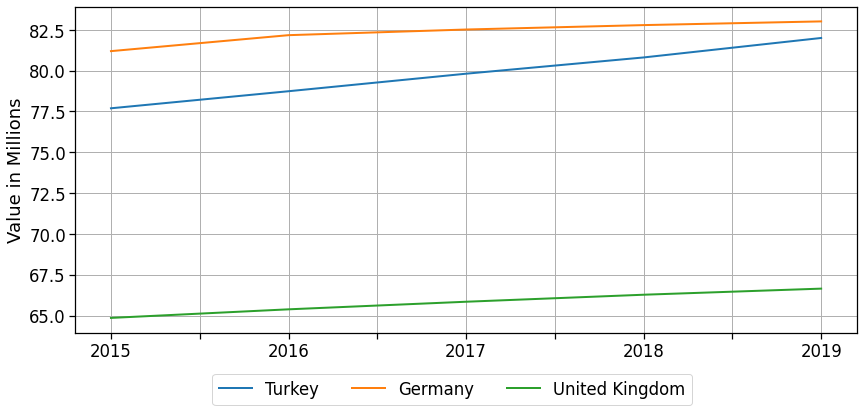

In [273]:
fig, ax = plt.subplots()
(overall_change/1e6).plot(ax=ax, figsize=(14, 6), ylabel='Value in Millions')
ax.legend(bbox_to_anchor=(0.8, -0.1), ncol=3)
plt.grid()

#### <u>2) Annual Change</u>

In [261]:
mag_change = growth_df.loc[:, '2015':'2019'].T.diff().fillna(0).cumsum()
mag_change

Country_Region,Turkey,Germany,United Kingdom
2015,0.0,0.0,0.0
2016,1045149.0,978147.0,525651.0
2017,2118967.0,1324116.0,990749.0
2018,3114621.0,1594814.0,1420183.0
2019,4307978.0,1821676.0,1793719.0


Plot below shows the how the cumulative sum of each population changed throughout the period:

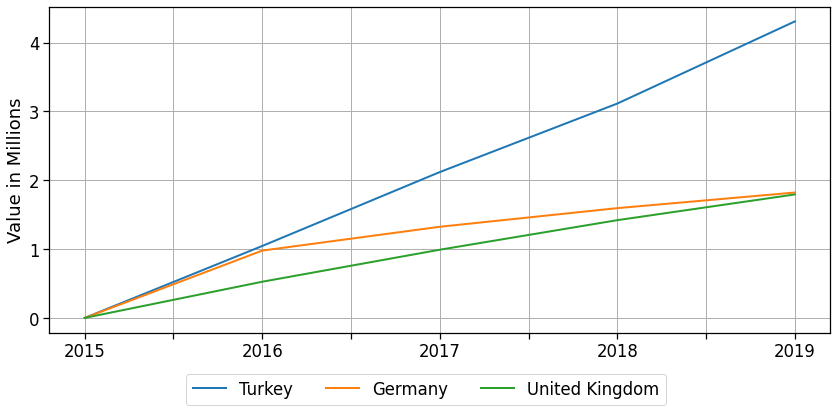

In [262]:
fig, ax = plt.subplots()
(mag_change/1e6).plot(ax=ax, figsize=(14, 6), ylabel='Value in Millions')
ax.legend(bbox_to_anchor=(0.8, -0.1), ncol=3)
plt.grid()

Let's get another angle - below is a function for a bar plot:

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [81]:
def plot_country_population_growth(df, direction):
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.despine()
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
    
    start = df['Year'].min()
    end = df['Year'].max()
    
    sns.barplot(x="Year", y="Population", data=df, hue='Country')
    ax.set_ylabel(ylabel='Population in Million', fontsize=12)
    ax.set_xlabel(xlabel='Year', fontsize=12)
    ax.set_title(f'Top 3 Highest Population {direction} {start}-{end}')
    ax.legend(bbox_to_anchor=(1.02, 0.75))

Reformat the data slightly in our 'top_3_growth' variable to get:

In [274]:
overall_change = overall_change.astype(np.int64).reset_index().rename(columns={'index': 'Year'}).melt(
    'Year',
    var_name='Country',
    value_name='Population'
)

overall_change

,Year,Country,Population
0,2015,Turkey,77695904
1,2016,Turkey,78741053
2,2017,Turkey,79814871
3,2018,Turkey,80810525
4,2019,Turkey,82003882
5,2015,Germany,81197537
6,2016,Germany,82175684
7,2017,Germany,82521653
8,2018,Germany,82792351
9,2019,Germany,83019213


And calling the function above, we get the following output:

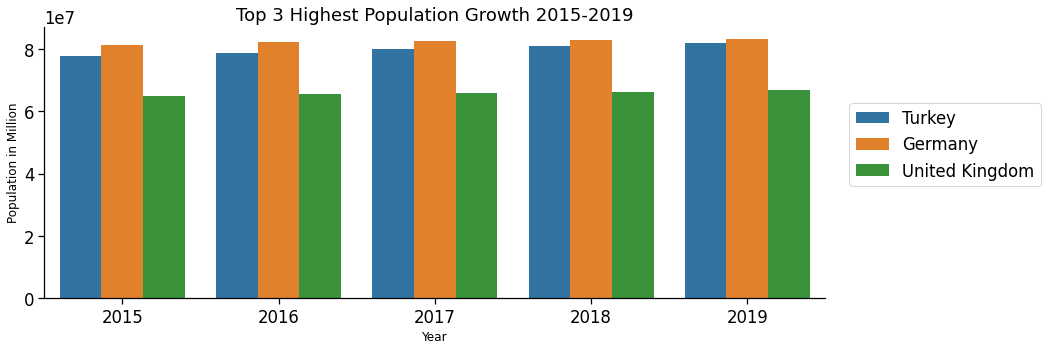

In [275]:
plot_country_population_growth(top_3_growth, 'Growth')

### b) Identify top 3 countries with highest population decline from 2010 to 2015. Present graphically.

For this question, we can largely repeat our steps from question a) and reuse the plotting function we created:

In [276]:
decline_df = df[df['type'] == 'country'].drop(columns='type')
decline_df['pop_change_2010_2015'] = decline_df['2015'] - decline_df['2010']
decline_df = decline_df.dropna().sort_values('pop_change_2010_2015').head(3)

In [277]:
top_3 = decline_df[['pop_change_2010_2015']].astype(np.int64).reset_index()
top_3.index += 1
top_3.columns = ['Country', 'Population Change 2010-15']
top_3

,Country,Population Change 2010-15
1,Ukraine,-3022931
2,Germany,-604720
3,Romania,-424036


#### <u>1) Overall Change</u>

In [282]:
overall_change = decline_df.loc[:, '2010':'2015'].T.astype(np.int64)
overall_change

Country_Region,Ukraine,Germany,Romania
2010,45782592,81802257,20294683
2011,45598179,80222065,20199059
2012,45453282,80327900,20095996
2013,45372692,80523746,20020074
2014,45245894,80767463,19947311
2015,42759661,81197537,19870647


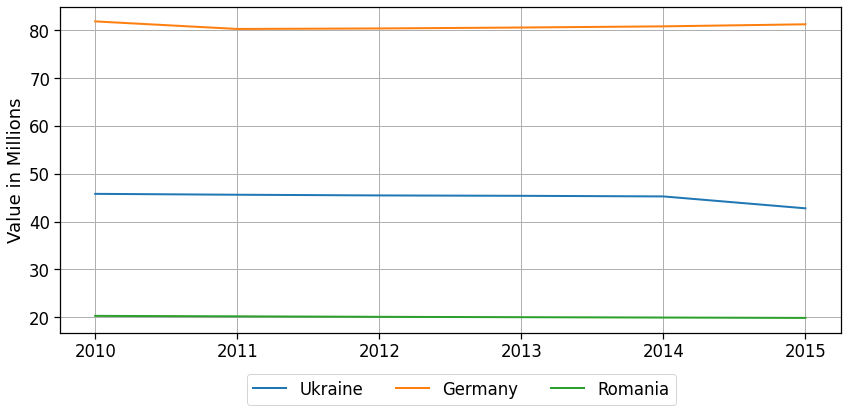

In [283]:
fig, ax = plt.subplots()
(overall_change/1e6).plot(ax=ax, figsize=(14, 6), ylabel='Value in Millions')
ax.legend(bbox_to_anchor=(0.8, -0.1), ncol=3)
plt.grid()

#### <u>2) Annual Change</u>

In [284]:
mag_change = decline_df.loc[:, '2010':'2015'].T.diff().fillna(0).cumsum()
mag_change

Country_Region,Ukraine,Germany,Romania
2010,0.0,0.0,0.0
2011,-184413.0,-1580192.0,-95624.0
2012,-329310.0,-1474357.0,-198687.0
2013,-409900.0,-1278511.0,-274609.0
2014,-536698.0,-1034794.0,-347372.0
2015,-3022931.0,-604720.0,-424036.0


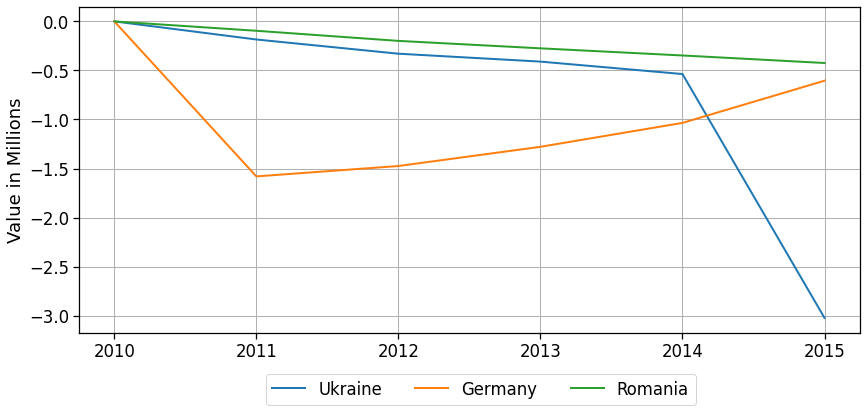

In [285]:
fig, ax = plt.subplots()
(mag_change/1e6).plot(ax=ax, figsize=(14, 6), ylabel='Value in Millions')
ax.legend(bbox_to_anchor=(0.8, -0.1), ncol=3)
plt.grid()

In [286]:
top_3_decline = top_3_decline.astype(np.int64).reset_index().rename(columns={'index': 'Year'}).melt(
    'Year',
    var_name='Country',
    value_name='Population'
)

top_3_decline

,Year,Country,Population
0,2010,Ukraine,45782592
1,2011,Ukraine,45598179
2,2012,Ukraine,45453282
3,2013,Ukraine,45372692
4,2014,Ukraine,45245894
5,2015,Ukraine,42759661
6,2010,Germany,81802257
7,2011,Germany,80222065
8,2012,Germany,80327900
9,2013,Germany,80523746


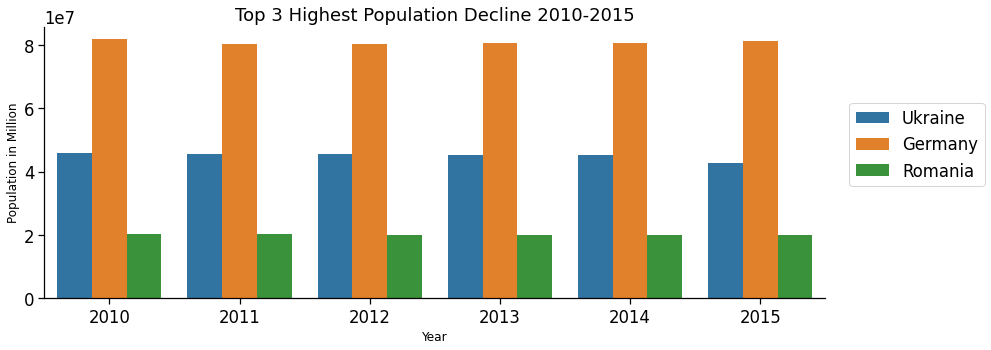

In [287]:
plot_country_population_growth(top_3_decline, 'Decline')

### c) Forecast population of the UK and Germany for 2020-2025. Explain your approach.<br>

For this question, I will use the ARIMA (Auto-Regressive Integrated Moving Average) to statistically model a prediction for the populations of the UK & Germany for 2020-2025.<br><br>Considering we have very little data to work with, we shall keep the forecasts simple by using default ARIMA model parameters per below.

#### <u>United Kingdom</u>

In [338]:
uk = df[df.index == 'United Kingdom'].drop(columns=['type']).astype(np.int64)/1e6
uk

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country_Region,,,,,,,,,,,,
United Kingdom,61.571647,62.042343,62.510197,63.022532,63.495088,63.905342,64.351203,64.853393,65.379044,65.844142,66.273576,66.647112


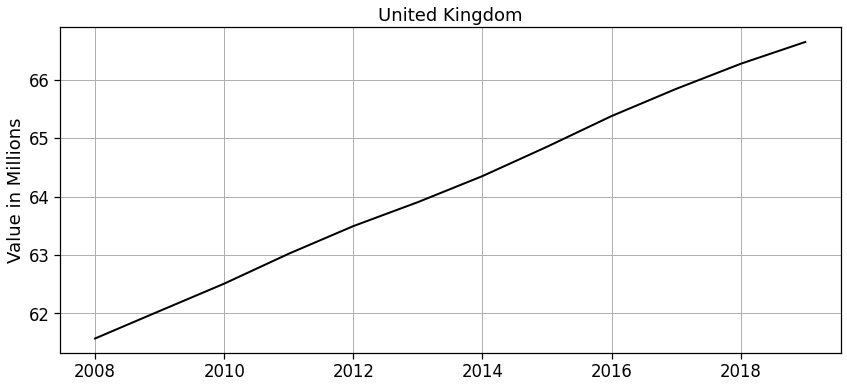

In [339]:
uk.T.plot(figsize=(14, 6), ylabel='Value in Millions', legend=False, color='black')
plt.title('United Kingdom')
plt.grid()

In [340]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(uk.T.values, order=(2, 1, 1))
model_fit = model.fit()

predictions = model_fit.predict(len(uk.T.values), len(uk.T.values) + 5)
print(f'The model predictions for UK population over next 5 years are:\n\n{list(predictions)}')

The model predictions for UK population over next 5 years are:

[66.98578921619824, 67.3371919796611, 67.67831630540351, 68.02033208084144, 68.35786422917768, 68.69354737700533]


c:\users\user\pycharmprojects\datascience\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\user\pycharmprojects\datascience\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [341]:
zipped = list(zip(range(2020, 2026), predictions))
for year, population in zipped:
    uk[year] = population

Plot the full model including predicted values:

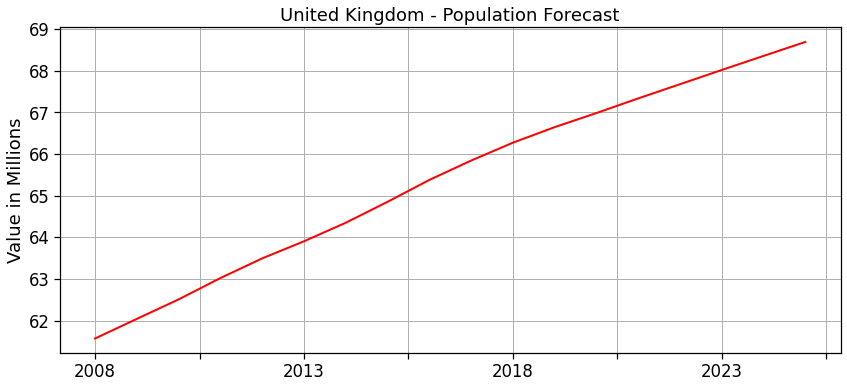

In [342]:
uk.T.plot(figsize=(14, 6), ylabel='Value in Millions', legend=False, color='red')
plt.title('United Kingdom - Population Forecast')
plt.grid()

#### <u>Germany</u>

In [348]:
germany = df[df.index == 'Germany'].drop(columns=['type']).astype(np.int64)/1e6
germany

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Country_Region,,,,,,,,,,,,
Germany,82.217837,82.002356,81.802257,80.222065,80.3279,80.523746,80.767463,81.197537,82.175684,82.521653,82.792351,83.019213


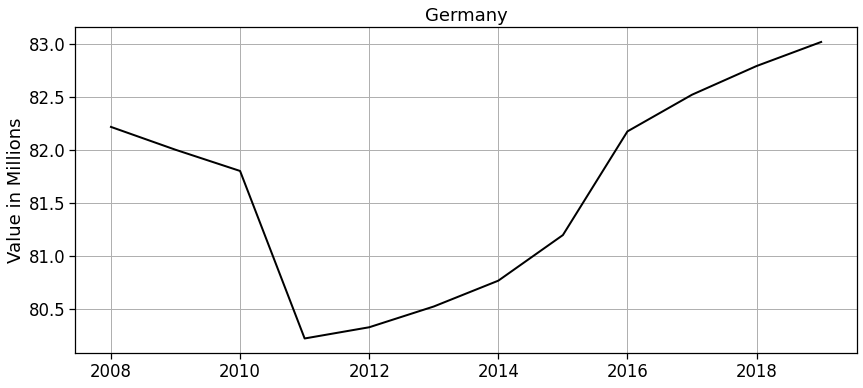

In [349]:
germany.T.plot(figsize=(14, 6), ylabel='Value in Millions', legend=False, color='black')
plt.title('Germany')
plt.grid()

In [350]:
model = ARIMA(germany.T.values, order=(2, 1, 1))
model_fit = model.fit()

predictions = model_fit.predict(len(germany.T.values), len(germany.T.values) + 5)
print(f'The model predictions for UK population over next 5 years are:\n\n{list(predictions)}')

The model predictions for UK population over next 5 years are:

[83.1077788901102, 83.15575260740788, 83.17761987230551, 83.18849992619309, 83.19367302004318, 83.19619060641975]


In [351]:
zipped = list(zip(range(2020, 2026), predictions))
for year, population in zipped:
    germany[year] = population

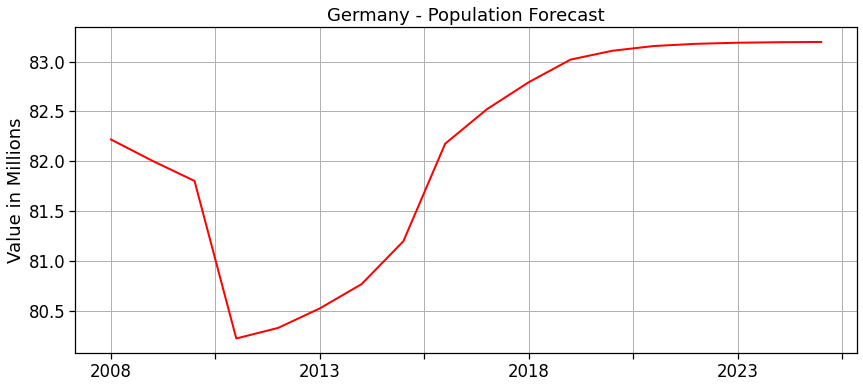

In [352]:
germany.T.plot(figsize=(14, 6), ylabel='Value in Millions', legend=False, color='red')
plt.title('Germany - Population Forecast')
plt.grid()

### d) Present the population data from 2008 and 2019 in a way that it is easy for the viewer to understand the magnitudes of population across the data set.<br>

For this question, I've split the data into separate frames depending on whether it is a region or a country for the sake of simplicity. Otherwise the shadings in the heatmap plots would be distorted by the much higher regional populations.

In [60]:
countries = df[df['type'] == 'country'].dropna().drop(columns=['type']).sort_index()
regions = df[df['type'] == 'region'].dropna().drop(columns=['type']).sort_index()

As above, for convenience we'll write a short function to automate the plotting:

In [105]:
def plot_heatmap(df, label, colour='Reds'):
    fig, ax = plt.subplots(figsize=(df.shape[0], df.shape[1]))
    sns.heatmap(ax=ax, data=df.T, linewidths=0.5, cmap=colour)
    ax.set_ylabel('Year', fontsize=20)
    ax.set_xlabel(label, fontsize=20)
    ax.invert_yaxis()

#### <u>Countries</u>

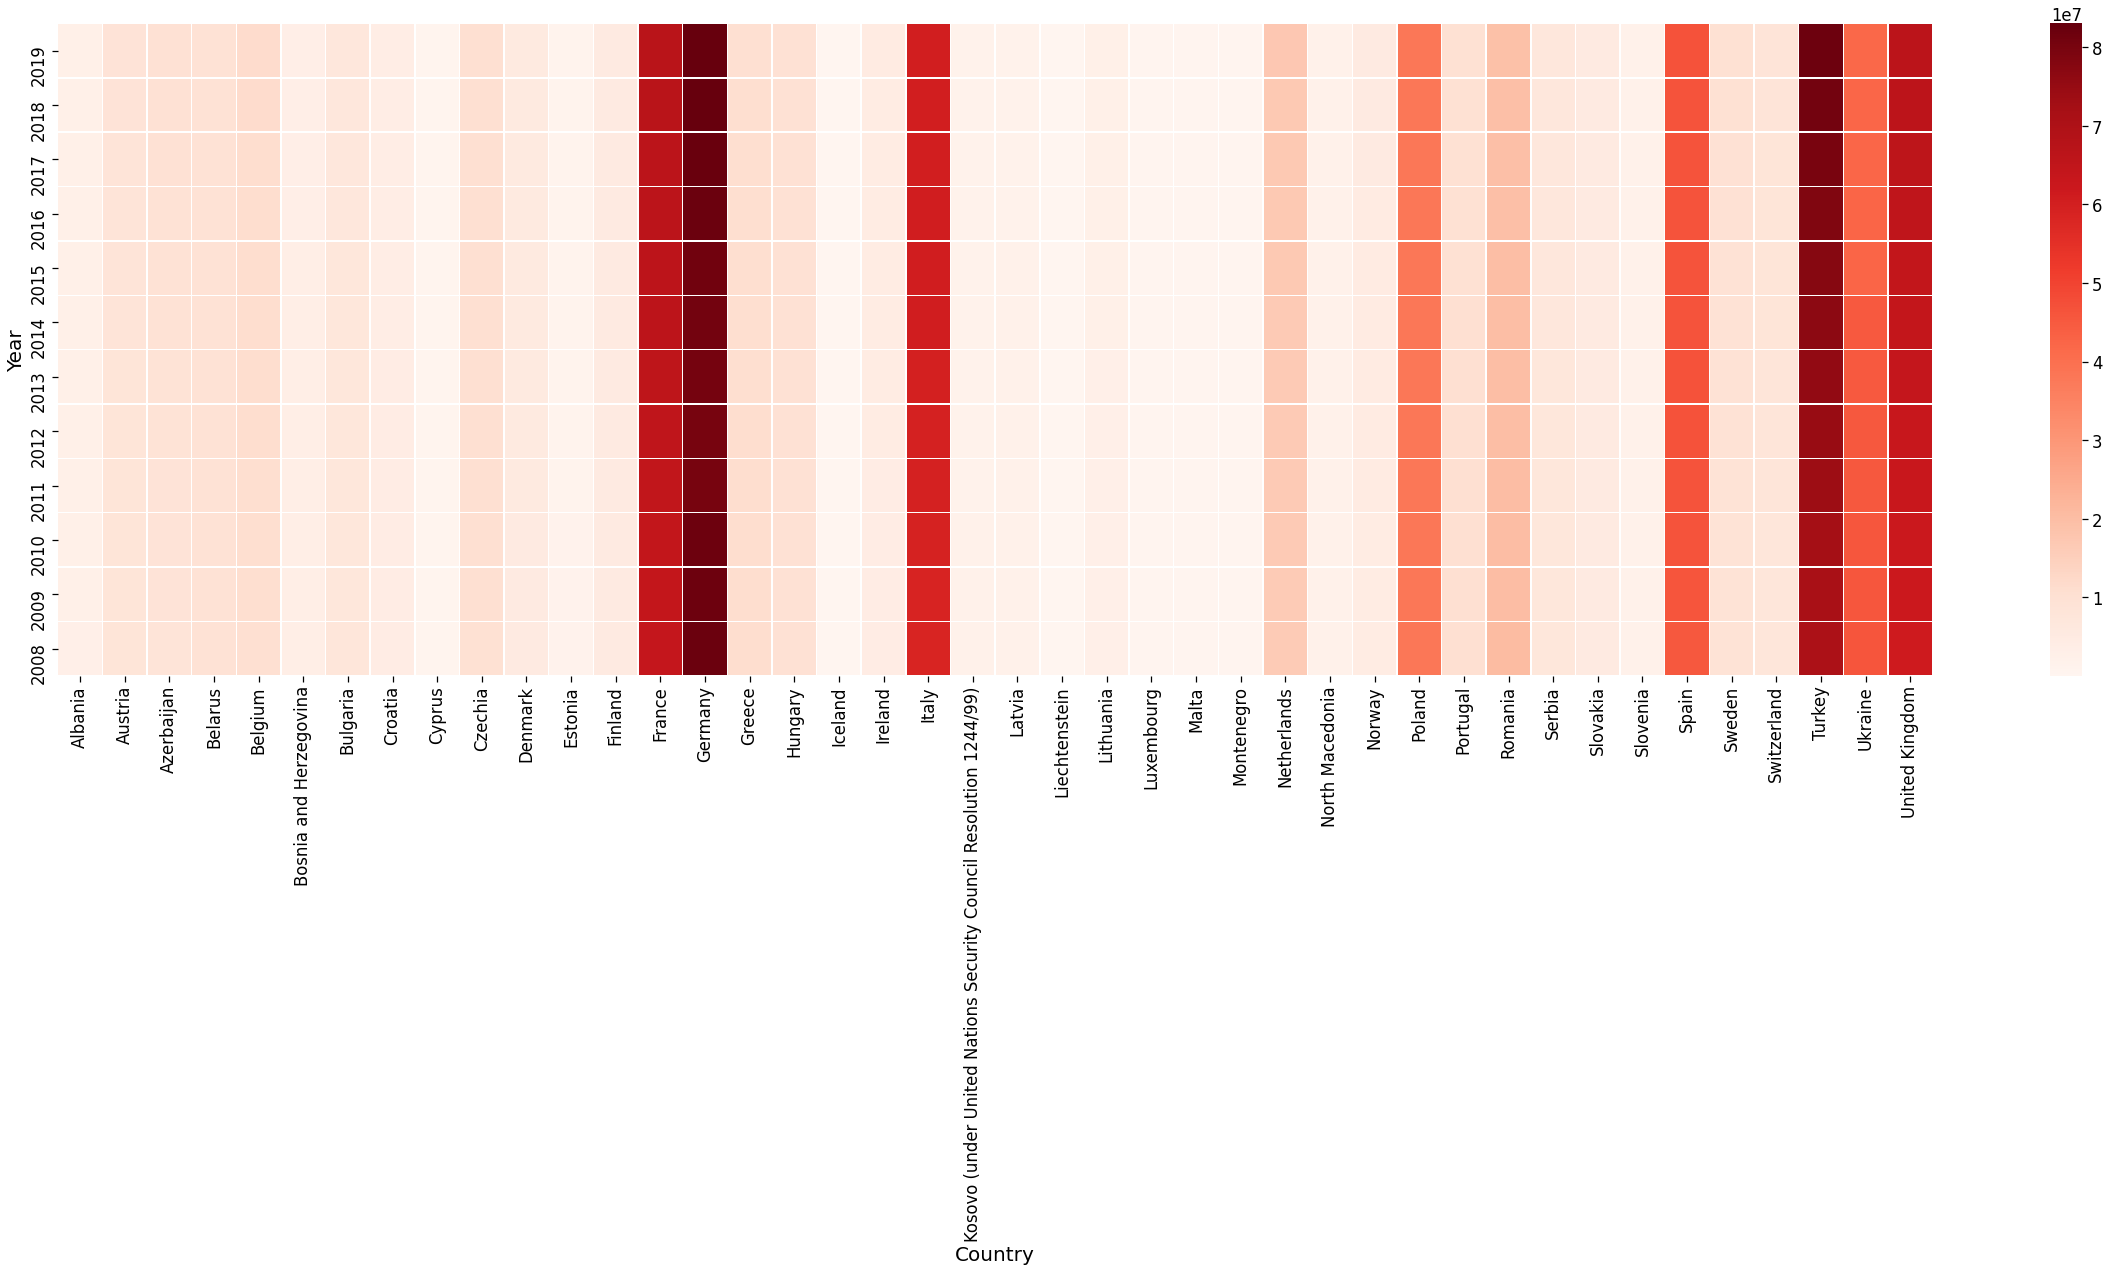

In [102]:
plot_heatmap(countries, 'Country')

#### <u>Regions</u>

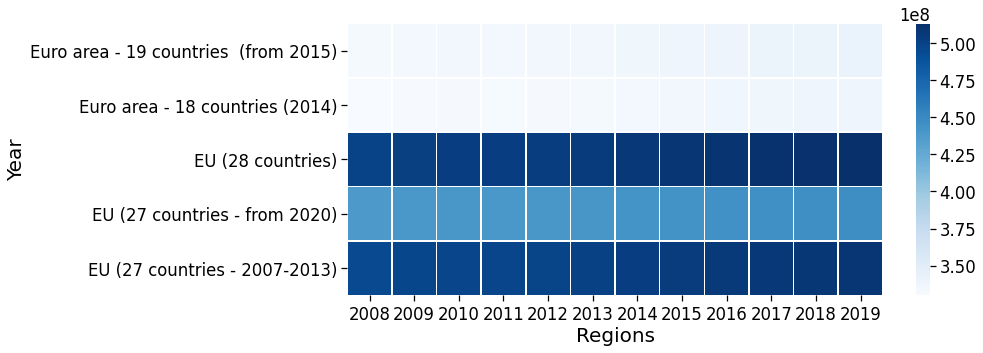

In [106]:
plot_heatmap(regions.T, 'Regions', colour='Blues')

### e) How did population of countries listed change from 2012 to 2013 (exclude countries with incomplete data)?<br>

Here we take a similar approach to above, first by filtering out regions to leave just countries for the analysis.<br><br>
We'll then calculate the sum of total population across the continent for the years 2012 and 2013 and print the difference between the figures, including total change as a percentage.

In [216]:
countries = df[df['type'] == 'country'].dropna().drop(columns=['type'])[['2012', '2013']].astype(np.int64)

total_pop_2012 = round(countries.sum()['2012'])
total_pop_2013 = round(countries.sum()['2013'])

population_change = total_pop_2013 - total_pop_2012
populations_percentage_change = round(100 * ((total_pop_2013 / total_pop_2012) - 1), 2)

print(f'Total Sum of Population in 2012: {total_pop_2012:,}')
print(f'Total Sum of Population in 2013: {total_pop_2013:,}')

print(f'Total Sum of Population Change for 2012-2013: +{population_change:,} (+{populations_percentage_change}%)')

Total Sum of Population in 2012: 674,641,162
Total Sum of Population in 2013: 676,846,195
Total Sum of Population Change for 2012-2013: +2,205,033 (+0.33%)


In [217]:
countries['Population Change 2012-13'] = countries['2013'] - countries['2012']
countries['% Change'] = round(100 * ((countries['2013'] / countries['2012']) - 1), 2)

top_5 = countries.sort_values('% Change', ascending=False).head(5)
bottom_5 = countries.sort_values('% Change').head(5)

#### Top 5 Country Population Changes 2012-13 by %

In [218]:
top_5.reset_index().replace('Kosovo (under United Nations Security Council Resolution 1244/99)', 'Kosovo')

,Country_Region,2012,2013,Population Change 2012-13,% Change
0,Luxembourg,524853,537039,12186,2.32
1,Kosovo,1780021,1815606,35585,2.00
2,Azerbaijan,9235085,9356483,121398,1.31
3,Norway,4985870,5051275,65405,1.31
4,Turkey,74724269,75627384,903115,1.21


#### Bottom 5 Country Population Changes 2012-13 by %

In [219]:
bottom_5.reset_index()

,Country_Region,2012,2013,Population Change 2012-13,% Change
0,Lithuania,3003641,2971905,-31736,-1.06
1,Latvia,2044813,2023825,-20988,-1.03
2,Greece,11086406,11003615,-82791,-0.75
3,Bulgaria,7327224,7284552,-42672,-0.58
4,Portugal,10542398,10487289,-55109,-0.52


#### Full Country Population Changes 2012-13

In [220]:
countries.sort_values('Population Change 2012-13', ascending=False)

,2012,2013,Population Change 2012-13,% Change
Country_Region,,,,
Turkey,74724269,75627384,903115,1.21
United Kingdom,63495088,63905342,410254,0.65
France,65276983,65600350,323367,0.50
Italy,59394207,59685227,291020,0.49
Germany,80327900,80523746,195846,0.24
Azerbaijan,9235085,9356483,121398,1.31
Switzerland,7954662,8039060,84398,1.06
Sweden,9482855,9555893,73038,0.77
Norway,4985870,5051275,65405,1.31


### Thank you for reading!